C:\Users\shich\AppData\Local\Temp\ipykernel_10232\2978604417.py:223: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t = (t << 1) | int(b)


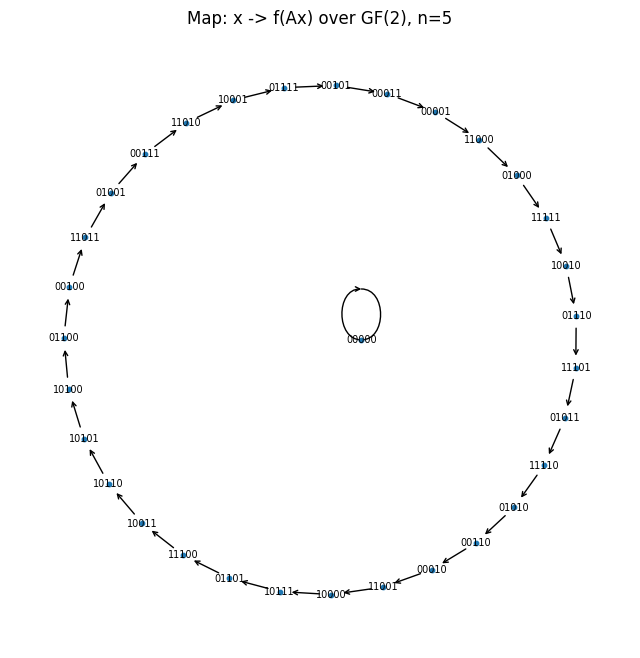

Matrix A (rows):
11111
01111
11000
11100
11110

Cycle lengths: [1, 31]
Number of cycles: 2

Trajectory from e1: 10000 -> 10111 -> 01101 -> 11100 -> 10011 -> 10110 -> 10101 -> 10100 -> 01100 -> 00100 -> 11011 -> 01001 -> 00111 -> 11010 -> 10001 -> 01111 -> 00101 -> 00011 -> 00001 -> 11000 -> 01000 -> 11111 -> 10010 -> 01110 -> 11101 -> 01011 -> 11110 -> 01010 -> 00110 -> 00010 -> 11001


In [ ]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def gf2_rank(mat):
    M = mat.copy() % 2
    M = M.astype(int)
    rows, cols = M.shape
    r = 0
    for c in range(cols):
        pivot = None
        for i in range(r, rows):
            if M[i, c] == 1:
                pivot = i
                break
        if pivot is None:
            continue
        if pivot != r:
            M[[r, pivot]] = M[[pivot, r]]
        for i in range(r + 1, rows):
            if M[i, c] == 1:
                M[i] ^= M[r]
        r += 1
        if r == rows:
            break
    return r


def int_to_vec(i, n):
    return tuple(((i >> (n - 1 - k)) & 1) for k in range(n))


def binary_to_gray(B):
    """
    Convert binary codes to Gray codes.
    B: ndarray of shape (..., n) with 0/1 ints
    """
    B = np.asarray(B) % 2
    G = B.copy()
    G[..., 1:] ^= B[..., :-1]
    return G


def gray_to_binary(G):
    """
    Convert Gray codes back to binary.
    G: ndarray of shape (..., n) with 0/1 ints
    """
    G = np.asarray(G) % 2
    B = G.copy()
    # cumulative XOR along the last axis
    for i in range(1, B.shape[-1]):
        B[..., i] ^= B[..., i - 1]
    return B


def debruijn_sequence(x):
    n = len(x)
    a = [0] * (2 * n)
    seq = []

    def db(t, p):
        if t > n:
            if n % p == 0:
                seq.extend(a[1 : p + 1])
        else:
            a[t] = a[t - p]
            db(t + 1, p)
            for j in range(a[t - p] + 1, 2):
                a[t] = j
                db(t + 1, t)

    db(1, 1)
    return np.array(seq, dtype=np.uint8)  # length = 2**n


def windows_from_debruijn(B):
    n = int(np.log2(len(B)))
    window_map = {}
    window_list = []

    for i in range(len(B)):
        w = tuple(int(B[(i + j) % len(B)]) for j in range(n))
        window_map[w] = i
        window_list.append(w)

    return window_map, window_list


def binary_to_bruijn(x):
    """
    Given a binary array x, return its index as a binary numpy array (one-hot style)
    in the de Bruijn cycle of length 2**n.
    """
    B = debruijn_sequence(x)
    window_map, _ = windows_from_debruijn(B)
    n = len(x)
    L = 2**n
    idx = window_map[tuple(int(b) for b in x)]

    # Convert index to binary array of length n
    idx_bin = np.array(list(np.binary_repr(idx, width=n)), dtype=np.uint8)
    return idx_bin


def bruijn_to_binary(idx_bin):
    """
    Given a binary np array idx_bin (from binary_to_bruijn),
    recover the original n-bit window.
    """
    n = len(idx_bin)
    idx = int("".join(idx_bin.astype(str)), 2)
    # Use a dummy array of length n to generate de Bruijn sequence
    x_dummy = np.zeros(n, dtype=np.uint8)
    B = debruijn_sequence(x_dummy)
    _, window_list = windows_from_debruijn(B)
    return np.array(window_list[idx], dtype=np.uint8)


def bitwise_not_bits(X):
    """
    Bitwise NOT for an array of binary bits (0/1).
    Returns 1-X.
    """
    X = np.asarray(X) % 2
    return 1 - X


def f(x):
    # TODO: search for such a good f(x) that it somehow improves the expected time to recover
    #    intuition why it may help: it mixes up the bits more nonlinearly
    # for now a example of a tromandous monster we can apply
    return x  # binary_to_gray(bruijn_to_binary(gray_to_binary(bitwise_not_bits(binary_to_bruijn((x + 7) % 2)))))


def apply_rule(A, x):
    x_arr = np.array(x, dtype=int)
    y = f(A.dot(x_arr) % 2)
    return tuple(int(b) for b in y)


def build_graph(A):
    n = A.shape[0]
    nodes = [int_to_vec(i, n) for i in range(2**n)]
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for x in nodes:
        y = apply_rule(A, x)
        G.add_edge(x, y)
    return G


def cycle_decomposition(A):
    n = A.shape[0]
    visited = set()
    cycles = []
    for i in range(2**n):
        v = int_to_vec(i, n)
        if v in visited:
            continue
        path = []
        cur = v
        while cur not in path:
            path.append(cur)
            cur = apply_rule(A, cur)
        idx = path.index(cur)
        cycle = path[idx:]
        for node in path:
            visited.add(node)
        cycles.append(cycle)
    return cycles


def gray_matrix_right_shift(n):
    # G = I + shift_right (zero-fill)
    G = np.eye(n, dtype=np.uint8)
    for i in range(n - 1):
        G[i, i + 1] = 1
    return G  # entries 0/1 (use XOR or mod2 after multiplication)


def gray_matrix_left_shift(n):
    G = np.eye(n, dtype=np.uint8)
    for i in range(1, n):
        G[i, i - 1] = 1
    return G


import numpy as np
from math import gcd


def companion_from_coeffs(a):
    """a = [a0,...,a_{N-1}] for x^N + a_{N-1}x^{N-1}+...+a0."""
    N = len(a)
    P = np.zeros((N, N), dtype=np.uint8)
    # shift-down ones
    P[1:, :-1] = np.eye(N - 1, dtype=np.uint8)
    # last column from coefficients
    for i in range(N):
        P[i, -1] = a[i]
    return P % 2


def primitive_matrix_from_bits(bits, P):
    """
    bits: 1D array/list of 0/1 of length L
    P   : fixed primitive N x N matrix over GF(2)
    """
    N = P.shape[0]
    m = (1 << N) - 1  # 2^N - 1

    # list all exponents k with gcd(k,m)=1
    units = [k for k in range(1, m) if gcd(k, m) == 1]
    units.sort()
    L = len(bits)

    # interpret bits as integer
    t = 0
    for b in bits:
        t = (t << 1) | int(b)

    # choose exponent
    k = units[t % len(units)]

    # fast exponentiation over GF(2)
    A = np.eye(N, dtype=np.uint8)
    base = P.copy()
    e = k
    while e > 0:
        if e & 1:
            A = (A @ base) % 2
        base = (base @ base) % 2
        e >>= 1
    return A


def random_invertible_matrix(n, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    P = np.array(
        [
            [0, 0, 0, 0, 1],
            [1, 0, 0, 0, 0],
            [0, 1, 0, 0, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0],
        ],
        dtype=np.uint8,
    )

    # Random u in {0,1}^n as column vector
    u = np.random.randint(0, 2, (n, 1), dtype=int)
    return primitive_matrix_from_bits(u, P)

    # GF(2) bitwise NOT: v = 1 - u
    v = 1 - u % 2

    # Identity matrix and Gray left shift matrix
    I = np.eye(n, dtype=int)
    G = gray_matrix_left_shift(n)

    # A = I + u v^T  in GF(2): addition is XOR
    A = I ^ (u @ v.T) % 2

    # Update A = GA
    A = G @ A % 2

    return A


# Parameters
n = 5
A = random_invertible_matrix(n)
G = build_graph(A)
cycles = cycle_decomposition(A)

start = int_to_vec(1 << (n - 1), n)  # e1 = 10000
traj = []
cur = start
seen = set()
while cur not in seen:
    seen.add(cur)
    traj.append(cur)
    cur = apply_rule(A, cur)

# Plot
plt.figure(figsize=(8, 8))
pos = nx.kamada_kawai_layout(G)
labels = {node: "".join(str(int(b)) for b in node) for node in G.nodes()}
nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_labels(G, pos, labels, font_size=7)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="->", arrowsize=8)
plt.title("Map: x -> f(Ax) over GF(2), n=5")
plt.axis("off")
plt.show()

# Print matrix and stats
print("Matrix A (rows):")
for row in A:
    print("".join(str(int(b)) for b in row))

print("\nCycle lengths:", sorted([len(c) for c in cycles]))
print("Number of cycles:", len(cycles))
print(
    "\nTrajectory from e1:", " -> ".join("".join(str(int(b)) for b in v) for v in traj)
)

In [35]:
import numpy as np
from itertools import product
from tqdm import tqdm


def gray_matrix_left_shift(n):
    G = np.zeros((n, n), dtype=int)
    for i in range(n - 1):
        G[i, i + 1] = 1
    G[n - 1, 0] = 1
    return G


def random_invertible_matrix(u, n):
    u = u.reshape((n, 1))
    P = np.array(
        [
            [0, 0, 0, 0, 1],
            [1, 0, 0, 0, 0],
            [0, 1, 0, 0, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0],
        ],
        dtype=np.uint8,
    )
    return primitive_matrix_from_bits(u, P)
    v = 1 - u % 2
    I = np.eye(n, dtype=int)
    G = gray_matrix_left_shift(n)
    A = I ^ (u @ v.T) % 2
    A = G @ A % 2
    return A


def is_full_rank_gf2(M):
    M = M.copy()
    n = M.shape[0]
    rank = 0
    for col in range(n):
        pivot_row = None
        for row in range(rank, n):
            if M[row, col] == 1:
                pivot_row = row
                break
        if pivot_row is not None:
            if pivot_row != rank:
                M[[rank, pivot_row]] = M[[pivot_row, rank]]
            for r in range(rank + 1, n):
                if M[r, col] == 1:
                    M[r] ^= M[rank]
            rank += 1
    return rank == n


# --- Main loop with logging duplicates ---
n = 5
matrix_map = {}  # key: matrix.tostring(), value: list of u vectors
all_fullrank = True

for u_tuple in tqdm(list(product([0, 1], repeat=n)), desc="Checking matrices"):
    u = np.array(u_tuple, dtype=int)
    A = random_invertible_matrix(u, n)

    # Check full rank
    if not is_full_rank_gf2(A):
        print("Matrix not full rank for u =", u)
        all_fullrank = False

    # Serialize matrix as bytes for dictionary key
    key = A.tobytes()
    if key not in matrix_map:
        matrix_map[key] = [u]
    else:
        # Duplicate found
        matrix_map[key].append(u)
        print(f"Duplicate matrix found for u = {u}")
        print(f"Other vectors with the same matrix: {matrix_map[key][:-1]}")

print(f"All matrices full-rank: {all_fullrank}")
print(f"Total unique matrices: {len(matrix_map)}")
print(f"Total matrices generated: {2**n}")

Checking matrices:   0%|          | 0/32 [00:00<?, ?it/s]C:\Users\shich\AppData\Local\Temp\ipykernel_10232\2978604417.py:223: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t = (t << 1) | int(b)
Checking matrices: 100%|██████████| 32/32 [00:00<00:00, 4034.44it/s]

Duplicate matrix found for u = [1 1 1 1 0]
Other vectors with the same matrix: [array([0, 0, 0, 0, 0])]
Duplicate matrix found for u = [1 1 1 1 1]
Other vectors with the same matrix: [array([0, 0, 0, 0, 1])]
All matrices full-rank: True
Total unique matrices: 30
Total matrices generated: 32


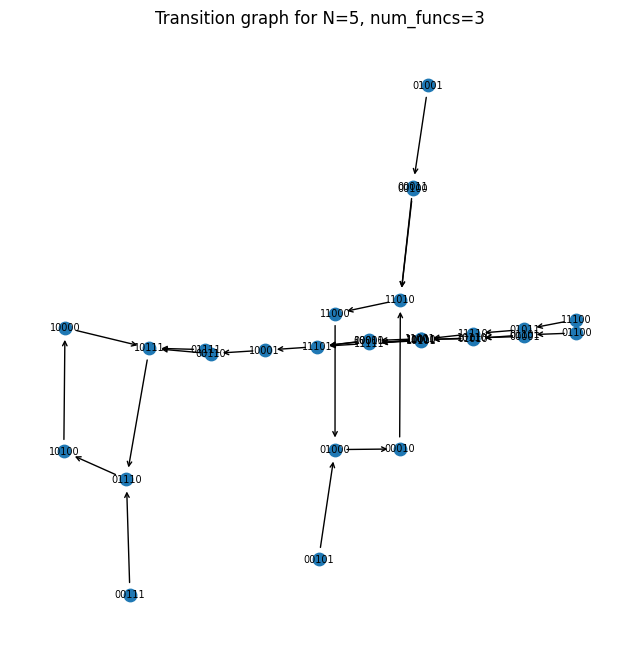

In [20]:
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

# ============================================================
#  Helpers: bits <-> int conversion
# ============================================================


def int_to_bits(x: int, N: int) -> np.ndarray:
    """Convert integer x into an N-bit vector (MSB first)."""
    return np.array([(x >> k) & 1 for k in range(N - 1, -1, -1)], dtype=np.uint8)


def bits_to_int(bits: np.ndarray) -> int:
    """Convert an N-bit vector (MSB first) to integer."""
    v = 0
    for b in bits:
        v = (v << 1) | int(b)
    return v


# ============================================================
#  Random ANF-based vector function f: {0,1}^N -> {0,1}^N
# ============================================================


def make_random_anf_vector_function(
    N: int,
    terms_per_coord: int = 4,
    max_degree: int | None = 3,
    rng: random.Random | None = None,
):
    """
    Build random nonlinear f: {0,1}^N -> {0,1}^N using ANF monomials.
    Each coordinate is:
        f_i(x) = c_i XOR (XOR of several monomials)
    """

    if rng is None:
        rng = random.Random()

    # Enumerate candidate monomial masks
    candidates = []
    for mask in range(1, 1 << N):  # exclude mask=0 (constant)
        if max_degree is not None and bin(mask).count("1") > max_degree:
            continue
        candidates.append(mask)

    coord_terms = []
    coord_const = []
    for _ in range(N):
        chosen = rng.sample(candidates, k=min(terms_per_coord, len(candidates)))
        coord_terms.append(chosen)
        coord_const.append(rng.randint(0, 1))

    def f(x_int: int) -> np.ndarray:
        out = np.zeros(N, dtype=np.uint8)
        for i in range(N):
            val = coord_const[i]
            for alpha in coord_terms[i]:
                if (x_int & alpha) == alpha:  # monomial evaluation
                    val ^= 1
            out[i] = val
        return out

    return f


# ============================================================
#  Build random update rule: x_{t+1} = XOR_k A_k f_k(x_t)
# ============================================================


def build_random_system(
    N: int,
    num_funcs: int = 3,
    terms_per_coord: int = 4,
    max_degree: int = 3,
    seed: int | None = None,
):
    rng = random.Random(seed)
    np_rng = np.random.default_rng(seed)

    fs = [
        make_random_anf_vector_function(
            N=N,
            terms_per_coord=terms_per_coord,
            max_degree=max_degree,
            rng=rng,
        )
        for _ in range(num_funcs)
    ]

    As = [np_rng.integers(0, 2, size=(N, N), dtype=np.uint8) for _ in range(num_funcs)]
    return As, fs


def next_state(x_int: int, As, fs, N: int) -> int:
    acc = np.zeros(N, dtype=np.uint8)
    for A, f in zip(As, fs):
        acc ^= (A @ f(x_int)) % 2
    return bits_to_int(acc)


# ============================================================
#  Build transition graph on 2^N states
# ============================================================


def build_transition_graph(N: int, As, fs):
    G = nx.DiGraph()
    num_states = 1 << N

    # add all states
    for x in range(num_states):
        bits = tuple(int_to_bits(x, N))
        G.add_node(bits)

    # transitions
    for x in range(num_states):
        x_bits = tuple(int_to_bits(x, N))
        y = next_state(x, As, fs, N)
        y_bits = tuple(int_to_bits(y, N))
        G.add_edge(x_bits, y_bits)

    return G


# ============================================================
#  Plotting
# ============================================================


def plot_transition_graph(G, title="Transitions"):
    plt.figure(figsize=(8, 8))
    pos = nx.kamada_kawai_layout(G)

    labels = {node: "".join(str(int(b)) for b in node) for node in G.nodes()}

    nx.draw_networkx_nodes(G, pos, node_size=80)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="->", arrowsize=8)
    nx.draw_networkx_labels(G, pos, labels, font_size=7)

    plt.title(title)
    plt.axis("off")
    plt.show()


# ============================================================
#  Example usage (run this cell as-is!)
# ============================================================

N = 5  # State size (packet size)
num_funcs = 3  # Number of nonlinear blocks
terms_per_coord = 4
max_degree = 3

As, fs = build_random_system(
    N=N,
    num_funcs=num_funcs,
    terms_per_coord=terms_per_coord,
    max_degree=max_degree,
)

G = build_transition_graph(N, As, fs)

plot_transition_graph(G, title=f"Transition graph for N={N}, num_funcs={num_funcs}")

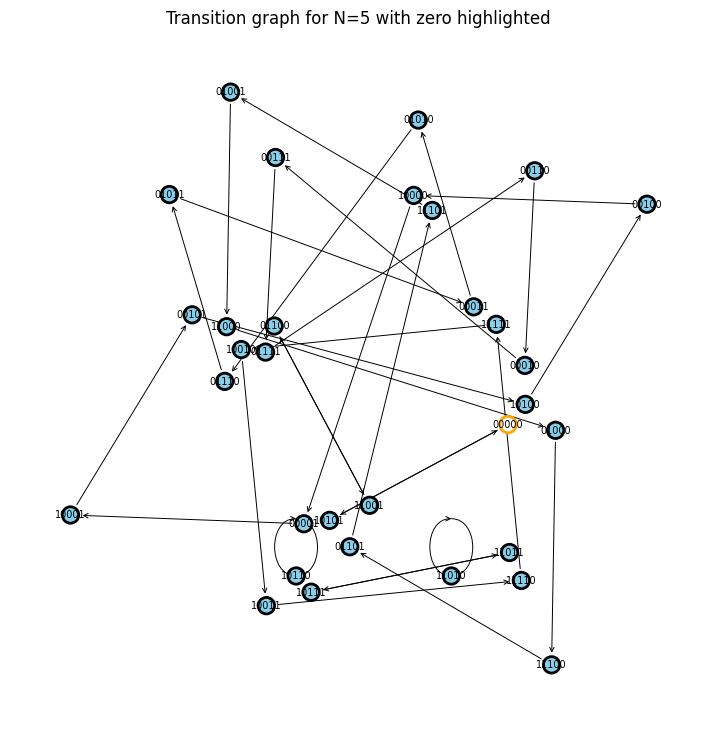

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


# same helpers
def int_to_bits(x, N):
    return [(x >> (N - 1 - i)) & 1 for i in range(N)]


def anf_feature_vector(x_bits, masks):
    xmask = 0
    for b in x_bits:
        xmask = (xmask << 1) | b
    return np.array([(1 if (xmask & m) == m else 0) for m in masks], dtype=np.uint8)


def next_state(x, A, masks, N):
    xb = np.array(int_to_bits(x, N), dtype=np.uint8)
    F = anf_feature_vector(xb, masks)
    yb = (A @ F) % 2
    y = 0
    for b in yb:
        y = (y << 1) | int(b)
    return y


def build_transition_graph(N, A, masks):
    G = nx.DiGraph()
    for x in range(1 << N):
        bits = tuple(int_to_bits(x, N))
        G.add_node(bits)
    for x in range(1 << N):
        xb = tuple(int_to_bits(x, N))
        y = next_state(x, A, masks, N)
        yb = tuple(int_to_bits(y, N))
        G.add_edge(xb, yb)
    return G


def plot_transition_graph(G, N, title="Transitions"):
    plt.figure(figsize=(9, 9))
    pos = nx.kamada_kawai_layout(G)
    labels = {node: "".join(str(int(b)) for b in node) for node in G.nodes()}

    # highlight zero node
    zero = tuple([0] * N)
    node_colors = []
    node_edgecolors = []
    for node in G.nodes():
        if node == zero:
            node_colors.append("white")
            node_edgecolors.append("orange")
        else:
            node_colors.append("skyblue")
            node_edgecolors.append("black")

    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=140,
        node_color=node_colors,
        edgecolors=node_edgecolors,
        linewidths=2,
    )
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="->", arrowsize=8, width=0.7)
    nx.draw_networkx_labels(G, pos, labels, font_size=7)
    plt.title(title)
    plt.axis("off")
    plt.show()


# Example
N = 5
m = 7
A = np.random.randint(0, 2, (N, m), dtype=np.uint8)
masks = list(range(1 << N))
masks.sort(key=lambda s: (bin(s).count("1"), s))
masks = masks[:m]

G = build_transition_graph(N, A, masks)
plot_transition_graph(G, N, title="Transition graph for N=5 with zero highlighted")